In [2]:
import os
import pysam
import remora
import sys
sys.path.append('..//')
import shannon_entropies as sp
import pod5
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import line_profiler as lprof

In [4]:
df = pd.read_csv("../../../data/large_working_directory/rough_consensus_output/consensus_sequence_Pool=AACCAAGACTCGCTGTGCCTAGTT-AGTCAGCT+AACTAGGCACAGCGAGTCTTGGTT-TTCCAGGA+XPOS[P:66].csv")

In [13]:
np.asarray(df['moves'][0])

array("array('b', [5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 

### Loading and Merging methods

In [2]:
def load_pod5_data(p5_path):
    
    # For some godforsaken reason, pod5 somehow consumes upwards of 6 GiB of memory when this runs, 
    # and it DOES NOT DISSAPEAR. ESLIT'rkjasvkajs;flksarejva;lkrvj
    data_list = []
    with pod5.Reader(p5_path) as pod5_file:
        reads = pod5_file.reads()
        for read in reads:
            seq_id = read.read_id
            signal = read.signal_pa
            freq = read.run_info.sample_rate
            data_dict = {'seq_id': str(seq_id),
                         'signal': signal,
                         'freq': freq}
            data_list.append(data_dict)
    pod5_file.close()
            
    return data_list

#https://pod5-file-format.readthedocs.io/en/latest/reference/api/pod5.reader.html#pod5.reader.ReadRecord

In [3]:
def merge_bam_reads_by_id(bam_list_dict, read_list_dict, consensus_list_dict):
        
    # this code can be made more time efficient and memory-chunking but that's not important rn
    bld = pd.DataFrame(bam_list_dict)
    rld = pd.DataFrame(read_list_dict)
    cld = pd.DataFrame(consensus_list_dict)
    
    merged_data_df = pd.merge(bld, rld, on='seq_id', how='left')
    
    for i in range(len(cld)):
        #merged_data_df.at[]
        indexes = merged_data_df[merged_data_df['ref_name'] == cld['id'][i]].index
        merged_data_df.loc[indexes,'ref_seq'] = cld['seq'][i]
    
    
    data_dict = merged_data_df.to_dict('records')

    return data_dict

### Signal Parsing Methods

In [4]:
def map_signal_to_moves(moves_table, offset, signal):
    if (str(signal) == 'nan'):
        return np.asarray([])
    else:
        # Generate an empty list to hold the true moves
        moves = []

        # get the raw moves, beginning after the first index
        raw_moves = list(moves_table[1:])

        # get the stride, beginning before the moves
        stride = moves_table[0]

        # Loop through the raw moves
        for i in range(len(raw_moves)):

            # if the raw move is zero
            if (raw_moves[i] == 0):

                # append n=stride zeroes
                for j in range(stride):
                    moves.append(0)

            # otherwise, append a 1 and then n-1 zeroes
            else:
                moves.append(1)
                for j in range(stride-1):
                    moves.append(0)

        # get the length difference between the signal+offset and the moves
        lendiff = (len(signal)+offset) - len(moves)

        # convert the moves to an array
        moves = np.asarray(moves)

        # pad the moves with zeroes for the offset and the length difference
        moves = np.pad(moves, (offset, lendiff), 'constant')

        # get the indexes where a stride step occurs
        stride_indicies = (np.where(moves == 1)[0])

        # add the last index as the length of the signal
        stride_indicies = np.append(stride_indicies, len(signal))

        # generate empty list to hold per-observation signals
        signal_list = []

        # loop through the stride indexes
        for i in range(len(stride_indicies)-1):

            # get beginning and end indexes
            begindex = stride_indicies[i]
            enddex = stride_indicies[i+1]

            # append the signal that falls between those indexes
            signal_list.append(signal[begindex:enddex])

        # return the list of observed signal segments
        return signal_list

In [188]:
def convert_signal_from_dict(m_list_dict):
    merged_data_df = pd.DataFrame(merged_list_dict)
    merged_data_df['signal'] = merged_data_df.apply(lambda x: map_signal_to_moves(x['moves'], x['trim_ofs'], x['signal']), axis=1)
    end_dict = merged_data_df.to_dict('records')
    del(merged_data_df)
    return end_dict

### Methods for aligning to the reference sequence

In [232]:
def align_observation_ops(cig, sig):
    
    # set up a dummy list to hold observations
    observation_dict_list = []
    
    # set up an indexer to index the operations by
    observation_indexer = 0

    # Loop through each observaiton in the cigar
    for observation in cig:
        
        # Get the observation type and duration
        ob_type = observation[0]
        ob_len = observation[1]
    
        # loop through the observation duration
        for i in range(ob_len):
            
            # insert the observation and the signal corresponding to that observation
            try:
                if ob_type == 2:
                    # The number of deletions correspond to the difference in signal count, so 
                    # a deletion means there is no signal at that observation (somehow)
                    observation_dict = {'operation':str(ob_type),
                                        'signal':None}
                    sig.insert(i+observation_indexer, None)
                    
                    # if it isnt a deletion, append the signal and operation
                else:
                    observation_dict = {'operation':str(ob_type),
                                        'signal':sig[i+observation_indexer]}
                    
            # if the above fails, it's probably because the signal list is empty, so append none.
            except:
                observation_dict = {'operation':str(ob_type),
                                    'signal':None}
                sig.insert(i+observation_indexer, None)

            # append the observation to the dummy list
            observation_dict_list.append(observation_dict)
            
        # index the observation indexer
        observation_indexer += ob_len
        
    # convert to a dataframe, and filter the not-so-valuable operations
    obs_df = pd.DataFrame(observation_dict_list)
    valued_operations = obs_df[(obs_df['operation'] != '4') |( obs_df['operation'] != '4')].reset_index(drop='true')

    # return the valued operations
    return valued_operations

In [209]:
def shift_to_alignment(ops, sigs, seq, quals, ref_len, r):
    # per-read alignment shifter
    
    # set up a dummy variable to hold the current base position
    base_position = 0
    
    # set up a list of the base keys
    base_keys = np.arange(ref_len).tolist()
    
    # set up empty dictionaries indexed by base position in the reference
    base_dict = {key:[] for key in base_keys}
    qual_dict =  {key:[] for key in base_keys}
    sig_dict = {key:[] for key in base_keys}
    
    # loop through each operation
    for i in range(len(ops)):
        op = ops[i]
        sig = sigs[i]
        
        shifted_bp = base_position + r
        # if it's a 0, we put the corresponding base in that index
        if (op == str(0)):
            # get the base at the base position in the sequence and append it,
            # likewise do the same for quality and signal
            base_dict[shifted_bp].append(seq[base_position])
            qual_dict[shifted_bp].append(quals[base_position])
            sig_dict[shifted_bp].append(sig)
            
            #index the base position by 1
            base_position += 1
        
        # if it's a 1, we have an insertion at that index
        elif (op == str(1)):
            
            # append the insertion indexer into the previous base position
            base_dict[shifted_bp-1].append("+")
            
            # append the quality to the previous base position
            qual_dict[shifted_bp-1].append(quals[base_position])
            
            # append the signal to the previous base position
            sig_dict[shifted_bp-1].append(sig)
            
            # delete the inserted base and quality to not get indexing errors
            del(seq[base_position])
            del(quals[base_position])
        
        # if it's a deletion,
        elif(op == str(2)):
            
            # insert a deletion indexer into the sequence and signals
            seq.insert(base_position, "-")
            quals.insert(base_position, None)
            
            # append the signal
            sig_dict[shifted_bp].append(sig)
            
            #append the deletion base
            base_dict[shifted_bp].append("-")
            
            # index the base position
            base_position += 1
            
    return [base_dict, qual_dict, sig_dict]

In [233]:
def parse_read_alignment_info(signal, cigar, ref_pos, qualities, read_sequence, reference_sequence):
    # per-row reader for the alignment info
    
    
    # Make copies to avoid issues with overwriting data
    sig = list(signal.copy())
    c = cigar.copy()
    r = int(ref_pos)
    q = qualities.copy()
    seq = list(read_sequence) 
    ref_seq_len = len(reference_sequence)
    
    # Align the signals to observations using the eponymous method w/
    # the cigar string, and the signals
    ops_and_signals = align_observation_ops(c, sig)
    
    # isolate the signals and operations:
    o = ops_and_signals['operation'].copy()
    op_sig = ops_and_signals['signal'].copy()
    
    # get the alignment dictionaries as a list of dicts
    dicts = shift_to_alignment(o, op_sig, seq, q, ref_seq_len, r)
    
    return dicts

In [211]:
def extract_alignment_from_dict(m_list_dict):
    # extract the alignment info from the merged dict
    e_df = pd.DataFrame(m_list_dict)
    e_df['alignment_data'] = e_df.apply(lambda x: parse_read_alignment_info(x['signal'],
                                                                            x['cigar'],
                                                                            x['ref'],
                                                                            x['quality'],
                                                                            x['sequence'],
                                                                            x['ref_seq']), axis = 1)
    out_dict = e_df.to_dict("records")
    del(e_df)
    return out_dict

### Cells for execution

In [7]:
# Load the paths
bam_path = "../../../data/large_working_directory/rough_consensus_output/large_align.bam"
pod5_path = "../../../data/large_working_directory/merged_pod5/merged.pod5"
ref_fasta = "../../../data/reads_large/230725_PZ_lib_v4_r10/fasta/good.fa"
"../../../data/large_working_directory/rough_consensus_output/prelim_data_merge.csv"

In [8]:
# Use the shannon entropy methods to load the bam
loaded_bam = sp.load_in_data(bam_path)
print('bamfile memory allocation:{} GiB'.format(sys.getsizeof(loaded_bam)*(9.3132*10**-10)))

bamfile memory allocation:0.00155696587488 GiB


In [9]:
#Load the consensus reference fasta using shannon entropy methods
consens = sp.consensus_formatter(ref_fasta)

print('consensus memory allocation:{} GiB'.format(sys.getsizeof(consens)*(9.3132*10**-10)))

consensus memory allocation:3.1590374400000004e-05 GiB


In [10]:
# Load the pod5 read data using load_pod5_data -- MEMORY LEAK FROM pod5!!!!
dl = load_pod5_data(pod5_path)

print('dl memory allocation:{} GiB'.format(sys.getsizeof(dl)*(9.3132*10**-10)))

dl memory allocation:0.00315675756864 GiB


In [11]:
# Merge the data
merged_list_dict = merge_bam_reads_by_id(loaded_bam, dl, consens)
print('merged dict memory allocation:{} GiB'.format(sys.getsizeof(merged_list_dict)*(9.3132*10**-10)))

merged dict memory allocation:0.00155696587488 GiB


In [1]:
# convert signal to piecewise by observation --- WHY DOES THIS CAUSE A MEMORY LEAK AS WELL?!?!?!?!
merged_signal_list_dict = convert_signal_from_dict(merged_list_dict)
print('merged signal memory allocation:{} GiB'.format(sys.getsizeof(merged_signal_list_dict)*(9.3132*10**-10)))

NameError: name 'convert_signal_from_dict' is not defined

In [ ]:
read_alignment_data = extract_alignment_from_dict(merged_signal_list_dict)
print('alignment memory allocation:{} GiB'.format(sys.getsizeof(read_alignment_data)*(9.3132*10**-10)))

In [191]:
export_dataframe = pd.DataFrame(read_alignment_data)
pd.to_csv(export)

Index(['seq_id', 'ref_name', 'sequence', 'quality', 'cigar', 'len', 'ref',
       'rev', 'moves', 'sig_len', 'trim_ofs', 'signal', 'freq', 'ref_seq'],
      dtype='object')

In [234]:
e_df = pd.DataFrame(merged_signal_list_dict)

def get_dicts(e, i):
    sig = e['signal'][i].copy()
    c = e['cigar'][i].copy()
    ops_and_signals = align_observation_ops(c, sig)
    r = e['ref'][i].copy()
    o_s = list(ops_and_signals['signal'])
    o = ops_and_signals['operation'].copy()
    q = e['quality'][i].copy()
    seq = list(e['sequence'][i])
    ref_seq_len = len(e['ref_seq'][i])
    dicts = shift_to_alignment(o, o_s, seq, q, ref_seq_len, r)
    del(sig)
    del(c)
    del(r)
    del(ops_and_signals)
    del(q)
    del(seq)
    
    return dicts, o, o_s

In [235]:

ops_str = ""
str_out = ""
str_out_2 = ""
ind = 1
got_dicts, operations, op_signals = get_dicts(e_df, ind)
for i in range(e_df['ref'][ind].copy()):
    str_out+= " "
    str_out_2 += " "
    ops_str += " "
str_out_2 += e_df['sequence'][ind]

for i in range(len(operations)):
    if (operations[i] == "1"):
        ops_str += "1"
    elif (type(operations[i]) != type(None)):
        ops_str += operations[i]
    else:
        ops_str += " "
        
for base in list(got_dicts[0].values()):
    if (base != []):
        str_out += base[0]
print("read:       "+str_out_2)
print("operations: "+ops_str)
print("true read:  "+str_out)
print("ref seq:    "+e_df['ref_seq'][i])


read:                        ATCACCCACACTTACTTCAGGACGTACACTTCCTGGAAACTGCCGATCGGGATCAGCAGTTTCCAGGAGATCACCTTGCTTTCCCTTCTTGATTGAATTGAAAAAAATTAGTACT
operations:                  000000000000000000000000000020200022001111000000002000000000000000000000000000000000000000000000000000000000000000000000
true read:                   ATCACCCACACTTACTTCAGGACGTACA-C-TTC--CTACTGCCGA-TCGGGATCAGCAGTTTCCAGGAGATCACCTTGCTTTCCCTTCTTGATTGAATTGAAAAAAATTAGTACT
ref seq:    AGTACTAATTTTTTTCGATATGGACTTTGGTAACTTCCTGCGTGATCAGTCAGCTACTGCTGATAGGGGGTCAGCAGTTTCCAGGAGATCCTACCGTCGAGTCAACAACGAAAGATCGAAAAAAATTAGTACT


In [182]:
for i in range(len(op_signals)):
    print(op_signals[i])

[145.47     143.38937  126.05088  124.31703  112.35347  113.047005
 117.208244 118.59533  117.38163  113.393776]
[114.95424 119.11548 117.38163 113.22039 107.49869]
[110.61961   98.82944   99.696365 101.08344  103.16406 ]
[106.458374 103.16406  110.27285  111.48654  103.16406 ]
[104.20438  107.3253   105.59145  109.57931  108.19223  103.51083
  99.86975  106.805145 110.793     89.813416]
[ 94.32143  129.51859  128.99843  117.208244 107.67207 ]
[104.20438 106.11161  98.30928 116.86147 116.86147]
[115.474396 112.87362   80.97079  111.48654  117.03486  117.7284
 119.635635 118.07517  118.42194  117.38163  116.51471  118.94209
 114.78085  117.555016 117.03486  115.64778  106.458374 104.20438
 108.19223  102.297134]
[ 94.84158   94.6682    93.80128   90.16019   91.894035  90.68034
  92.76096  112.52685  112.180084 113.74055 ]
[111.48654  116.341324 115.127625 110.793    114.78085 ]
[119.288864 112.35347  122.23641  117.90179  119.46225  117.38163
 118.76871  117.38163  119.98241  121.88964 

In [177]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.DataFrame(got_dicts)

,0,1,2,3,4,5,6,7,8,9,...,123,124,125,126,127,128,129,130,131,132
0,[],[],[],[],[],[],[],[],[],[],...,[A],[A],[T],[T],[A],[G],[T],[A],[C],[T]
1,[],[],[],[],[],[],[],[],[],[],...,[30],[32],[20],[20],[20],[22],[24],[22],[22],[23]
2,[],[],[],[],[],[],[],[],[],[],...,"[[121.02271, 121.54287, 89.9868, 77.50308, 75.94262]]","[[68.31368, 67.793526, 68.48707, 67.96691, 70.91446]]","[[69.70076, 92.93435, 96.055275, 99.52298, 94.14804]]","[[96.22866, 79.75709, 80.97079, 79.06355, 79.75709, 76.80955, 73.862, 76.80955, 74.55554, 89.46665]]","[[87.7328, 95.535126, 130.90565, 128.30489, 129.69197, 125.35734, 126.05088, 126.39765, 123.796875, 117.555016]]","[[112.70023, 113.91393, 117.555016, 118.07517, 117.38163]]","[[116.341324, 118.94209, 115.82117, 117.555016, 120.84933]]","[[116.16794, 116.51471, 118.94209, 126.74442, 121.02271, 116.341324, 117.555016, 107.84546, 105.24468, 104.55114]]","[[104.724525, 99.17621, 88.42634, 88.77311, 89.9868]]","[[89.29327, 86.34572, 83.91833, 73.862, 77.329704, 79.410324, 80.97079, 82.357864, 77.15632, 78.543396, 78.89017, 77.15632, 78.37001, 82.357864, 77.329704, 80.97079, 75.249084, 76.28939, 75.94262, 73.51523]]"


In [9]:
# Loop through this section for each read in the data, in other words: Turn into its own method that is then
# Applied to the merged_data_df, or even the merged_data_df thats merged with the consnensus fasta------------
# Extract the stride, raw moves, signal, of the first read
index = 1
stride = merged_data_df.iloc[index]['moves'][0]
raw = merged_data_df.iloc[index]['moves'][1:]
sig = merged_data_df.iloc[index]['signal']

# split the signal into discrete parts by the moves
split_sig = split_signal(stride, raw, sig)

# Get cigar string and reference position
cig_seq = merged_data_df['cigar'][index]
ref_pos = merged_data_df['ref'][index]

# Use the signal, cigar, and reference to get the valued operations and signals
val_ops = align_observation_ops(cig_seq, sig, ref_pos)

# get the operation series as a string:
operations = val_ops['operation'].apply(str)

# get the quality scores for the current read
qual = merged_data_df['quality'][index]

# get the signal as the list
signals = list(val_ops['signal'])

# get the read sequence as a list
seq_list = list(merged_data_df['sequence'][index])

#get the reference sequence id
ref_seq_id = merged_data_df['ref_name'][index]

# get the reference sequence length
ref_length = len(cons_df[cons_df['id'] == ref_seq_id]['seq'].values[0])

# Get the alignment shift:

alignment_shift = shift_to_alignment(operations, signals, seq_list, qual, ref_length)
# ------- This should probably use .apply(), but there may be memory issues.

NameError: name 'cons_df' is not defined

4282


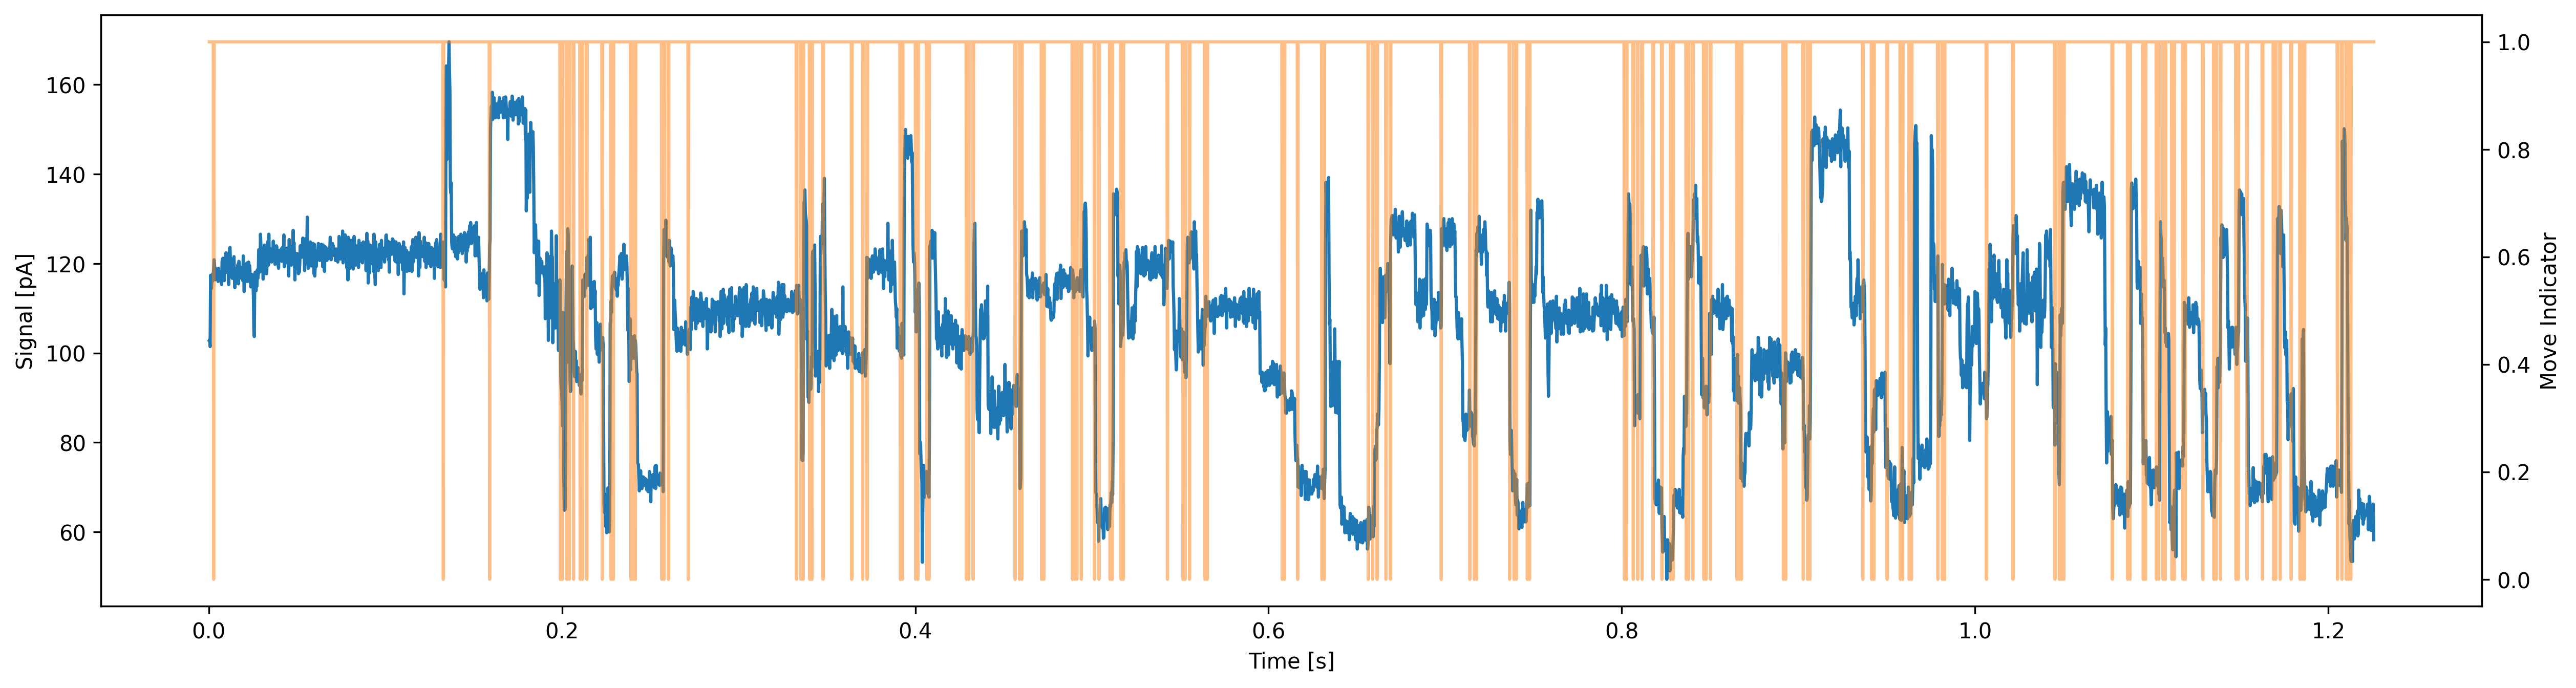

In [93]:

'''
counts_dict = dict(merged_data_df.groupby('ref_name').size())
max(counts_dict, key=counts_dict.get)
'''

print(len(moves_true))
fig, ax = plt.subplots(1, 1, figsize = (20, 5), dpi = 300)

ax.plot(t_sig, sig)
ax.set_ylabel('Signal [pA]')
ax.set_xlabel('Time [s]')
ax2 = ax.twinx()
ax2.plot(t_mv, moves, c='tab:orange', alpha = .5)
ax2.set_ylabel('Move Indicator')

plt.savefig('Move_table_and_signal.png')



In [36]:
profiler = lprof.LineProfiler()
def merge_bam_reads_by_id(bam_list_dict, read_list_dict, consensus_list_dict):
        
    read_ids = [str(x['seq_id']) for x in bam_list_dict][:10]
    
    merged_bam_reads = []
    for i in range(len(read_ids)):
        #print("{}/{}     ".format(i, len(read_ids)), end='\r')
        read = read_ids[i]
        bam_read_dict = list(d for d in bam_list_dict if d["seq_id"] == read)[0]
        raw_read_ls = list(d for d in read_list_dict if d["seq_id"] == read)
        if len(raw_read_ls) > 0:
            raw_read_dict = raw_read_ls[0]

            bam_read_dict['signal'] = raw_read_dict['signal']
            bam_read_dict['freq'] = raw_read_dict['freq']
            merged_bam_reads.append(bam_read_dict)
        
    

    return merged_bam_reads

profiled_func = profiler(merge_bam_reads_by_id)
profiled_func(loaded_bam, dl, consens) 
profiler.print_stats()

Timer unit: 1e-09 s

Total time: 0.639848 s
File: /tmp/ipykernel_29956/237270870.py
Function: merge_bam_reads_by_id at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           def merge_bam_reads_by_id(bam_list_dict, read_list_dict, consensus_list_dict):
     3                                               
     4         1   44547050.0    4e+07      7.0      read_ids = [str(x['seq_id']) for x in bam_list_dict][:10]
     5                                               
     6         1       1031.0   1031.0      0.0      merged_bam_reads = []
     7        11      11536.0   1048.7      0.0      for i in range(len(read_ids)):
     8                                                   #print("{}/{}     ".format(i, len(read_ids)), end='\r')
     9        10       7081.0    708.1      0.0          read = read_ids[i]
    10        10  374431873.0    4e+07     58.5          bam_read_dict = list(d for d in bam_list_dict if d["seq_id

In [ ]:
all_keys

In [8]:
sys.getsizeof(merged_data_df)

6868089114

In [ ]:
merged_data_df['reference_seq'] = merged_data_df['ref_name'].apply(lambda x: get_ref_by_id(x, cons_df))

In [17]:
merged_data_df['ref_name'][0]

'Pool=ACGTAACTTGGTTTGTTCCCTGAA-AGTCAGCT+CGAGGAGGTTCACTGGGTAGTAAG-TTCCAGGA+XPOS[P:66]'

In [18]:
merged_data_df['ref_name'][0]

False

In [22]:
merged_data_df['ref_name'][0] in cons_df['id']

False

In [ ]:
def get_alignment_info(, ):